In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import chi2_contingency
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import lightgbm as lgb
from sklearn.metrics import confusion_matrix,roc_curve,auc

# Reading The Dataset

In [2]:
df = pd.read_csv(r'/kaggle/input/playground-series-s4e11/train.csv')

In [3]:
df.shape

(140700, 20)

In [4]:
df.sample(5)

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
83808,83808,Gauri,Female,30.0,Visakhapatnam,Student,NaN,2.0,NaN,5.78,5.0,NaN,More than 8 hours,Healthy,B.Arch,Yes,7.0,3.0,Yes,1
43511,43511,Raghav,Male,24.0,Bangalore,Student,NaN,3.0,NaN,8.25,1.0,NaN,7-8 hours,Unhealthy,B.Tech,Yes,0.0,3.0,Yes,0
63799,63799,Tushar,Male,55.0,Delhi,Working Professional,Teacher,NaN,3.0,NaN,NaN,1.0,Less than 5 hours,Moderate,B.Ed,Yes,4.0,2.0,No,0
75381,75381,Armaan,Male,53.0,Chennai,Working Professional,Content Writer,NaN,5.0,NaN,NaN,5.0,Less than 5 hours,Healthy,M.Ed,Yes,8.0,5.0,No,0
70353,70353,Pratham,Male,41.0,Delhi,Working Professional,Consultant,NaN,2.0,NaN,NaN,4.0,5-6 hours,Moderate,PhD,No,4.0,4.0,No,0


In [5]:
df.isnull().sum()

id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

In [6]:
(df.isnull().sum()/df.shape[0])*100

id                                        0.000000
Name                                      0.000000
Gender                                    0.000000
Age                                       0.000000
City                                      0.000000
Working Professional or Student           0.000000
Profession                               26.034115
Academic Pressure                        80.172708
Work Pressure                            19.842217
CGPA                                     80.171997
Study Satisfaction                       80.172708
Job Satisfaction                         19.836532
Sleep Duration                            0.000000
Dietary Habits                            0.002843
Degree                                    0.001421
Have you ever had suicidal thoughts ?     0.000000
Work/Study Hours                          0.000000
Financial Stress                          0.002843
Family History of Mental Illness          0.000000
Depression                     

In [7]:
df = df.drop(['id','Name','Academic Pressure','CGPA','Study Satisfaction'],axis=1)

In [8]:
(df.isnull().sum()/df.shape[0])*100

Gender                                    0.000000
Age                                       0.000000
City                                      0.000000
Working Professional or Student           0.000000
Profession                               26.034115
Work Pressure                            19.842217
Job Satisfaction                         19.836532
Sleep Duration                            0.000000
Dietary Habits                            0.002843
Degree                                    0.001421
Have you ever had suicidal thoughts ?     0.000000
Work/Study Hours                          0.000000
Financial Stress                          0.002843
Family History of Mental Illness          0.000000
Depression                                0.000000
dtype: float64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 15 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Gender                                 140700 non-null  object 
 1   Age                                    140700 non-null  float64
 2   City                                   140700 non-null  object 
 3   Working Professional or Student        140700 non-null  object 
 4   Profession                             104070 non-null  object 
 5   Work Pressure                          112782 non-null  float64
 6   Job Satisfaction                       112790 non-null  float64
 7   Sleep Duration                         140700 non-null  object 
 8   Dietary Habits                         140696 non-null  object 
 9   Degree                                 140698 non-null  object 
 10  Have you ever had suicidal thoughts ?  140700 non-null  

In [10]:
for col in df.columns.to_list():
    print(f'{col}->{df[col].nunique()}')

Gender->2
Age->43
City->98
Working Professional or Student->2
Profession->64
Work Pressure->5
Job Satisfaction->5
Sleep Duration->36
Dietary Habits->23
Degree->115
Have you ever had suicidal thoughts ?->2
Work/Study Hours->13
Financial Stress->5
Family History of Mental Illness->2
Depression->2


# Handling Missing Data

<Axes: >

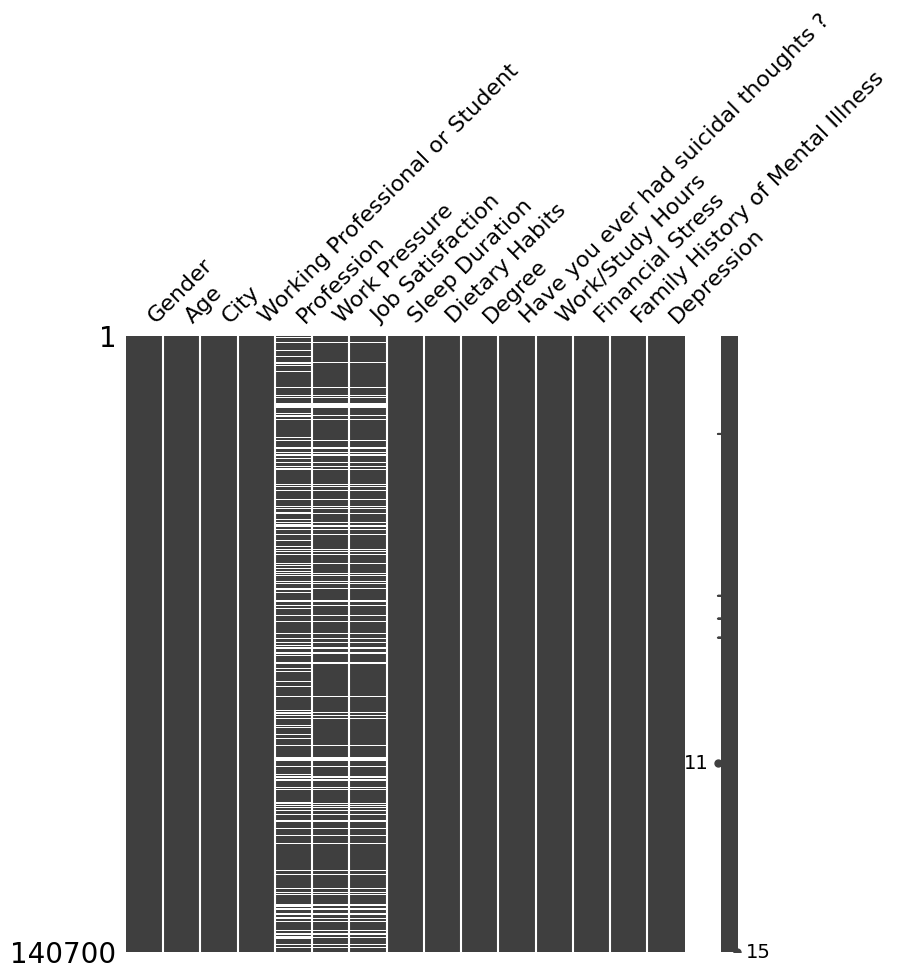

In [11]:
msno.matrix(df, figsize=(8, 8))

<Axes: >

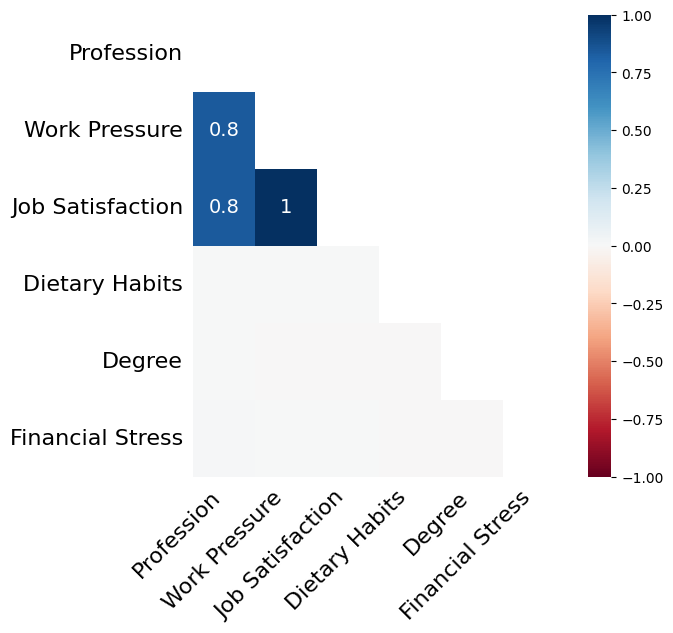

In [12]:
msno.heatmap(df,figsize=(6,6))

In [13]:
label = LabelEncoder()
df['Profession_no'] = label.fit_transform(df['Profession'])
label_classes_dict = {index: class_label for index, class_label in enumerate(label.classes_)}

In [14]:
label_classes_dict

{0: 'Academic',
 1: 'Accountant',
 2: 'Analyst',
 3: 'Architect',
 4: 'B.Com',
 5: 'B.Ed',
 6: 'BBA',
 7: 'BCA',
 8: 'BE',
 9: 'Business Analyst',
 10: 'Chef',
 11: 'Chemist',
 12: 'City Manager',
 13: 'Civil Engineer',
 14: 'Consultant',
 15: 'Content Writer',
 16: 'Customer Support',
 17: 'Data Scientist',
 18: 'Dev',
 19: 'Digital Marketer',
 20: 'Doctor',
 21: 'Educational Consultant',
 22: 'Electrician',
 23: 'Entrepreneur',
 24: 'Family Consultant',
 25: 'FamilyVirar',
 26: 'Finanancial Analyst',
 27: 'Financial Analyst',
 28: 'Graphic Designer',
 29: 'HR Manager',
 30: 'Investment Banker',
 31: 'Judge',
 32: 'LLM',
 33: 'Lawyer',
 34: 'M.Ed',
 35: 'MBA',
 36: 'MBBS',
 37: 'Manager',
 38: 'Marketing Manager',
 39: 'Mechanical Engineer',
 40: 'Medical Doctor',
 41: 'Moderate',
 42: 'Nagpur',
 43: 'Patna',
 44: 'PhD',
 45: 'Pharmacist',
 46: 'Pilot',
 47: 'Plumber',
 48: 'Pranav',
 49: 'Profession',
 50: 'Research Analyst',
 51: 'Researcher',
 52: 'Sales Executive',
 53: 'Software 

In [15]:
df['Profession_no'] = df['Profession_no'].map(lambda x: np.nan if x == 64 else x)

### Iterative Imputing

In [16]:
columns_to_impute = ['Profession_no', 'Work Pressure', 'Job Satisfaction']
data_subset = df[columns_to_impute]
lr = RandomForestClassifier(random_state=0,n_estimators=50)
mice_imputer = IterativeImputer(estimator=lr, max_iter=10, random_state=0, initial_strategy='most_frequent')
imputed_data = mice_imputer.fit_transform(data_subset)
data_imputed = pd.DataFrame(imputed_data, columns=columns_to_impute)
df[columns_to_impute] = data_imputed

In [17]:
df['Profession_no'] = np.round(df['Profession_no']).astype(int)
df['Profession_no'] = label.inverse_transform(df['Profession_no'])

In [18]:
df = df.dropna(subset=['Dietary Habits', 'Degree', 'Financial Stress'], axis=0)

In [19]:
df.drop('Profession',axis=1,inplace=True)

In [20]:
df.rename({'Profession_no':'Profession'},axis=1,inplace=True)

In [21]:
(df.isnull().sum()/df.shape[0])*100

Gender                                   0.0
Age                                      0.0
City                                     0.0
Working Professional or Student          0.0
Work Pressure                            0.0
Job Satisfaction                         0.0
Sleep Duration                           0.0
Dietary Habits                           0.0
Degree                                   0.0
Have you ever had suicidal thoughts ?    0.0
Work/Study Hours                         0.0
Financial Stress                         0.0
Family History of Mental Illness         0.0
Depression                               0.0
Profession                               0.0
dtype: float64

In [22]:
df.sample(5)

,Gender,Age,City,Working Professional or Student,Work Pressure,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Profession
6309,Male,56.0,Varanasi,Working Professional,1.0,5.0,5-6 hours,Moderate,M.Pharm,Yes,2.0,1.0,Yes,0,Doctor
85156,Male,33.0,Kanpur,Working Professional,1.0,4.0,5-6 hours,Unhealthy,BE,Yes,11.0,2.0,Yes,0,Entrepreneur
106884,Male,36.0,Vadodara,Working Professional,3.0,5.0,5-6 hours,Unhealthy,B.Arch,No,12.0,2.0,No,0,Teacher
120749,Male,33.0,Kolkata,Student,5.0,1.0,7-8 hours,Moderate,M.Pharm,No,4.0,3.0,No,1,Teacher
14695,Male,41.0,Ghaziabad,Working Professional,1.0,2.0,Less than 5 hours,Unhealthy,BSc,Yes,1.0,5.0,Yes,0,Consultant


# EDA

<Axes: xlabel='Depression', ylabel='count'>

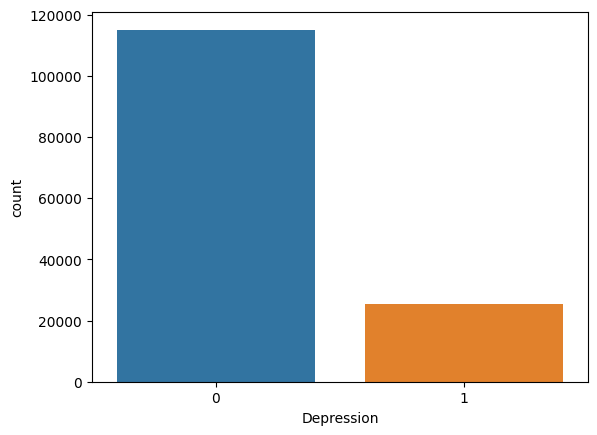

In [23]:
sns.countplot(data=df,x='Depression')

<Axes: xlabel='Gender', ylabel='count'>

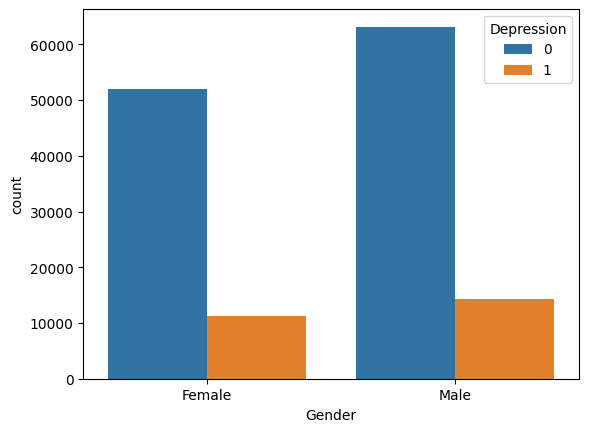

In [24]:
sns.countplot(data=df,x='Gender',hue='Depression')

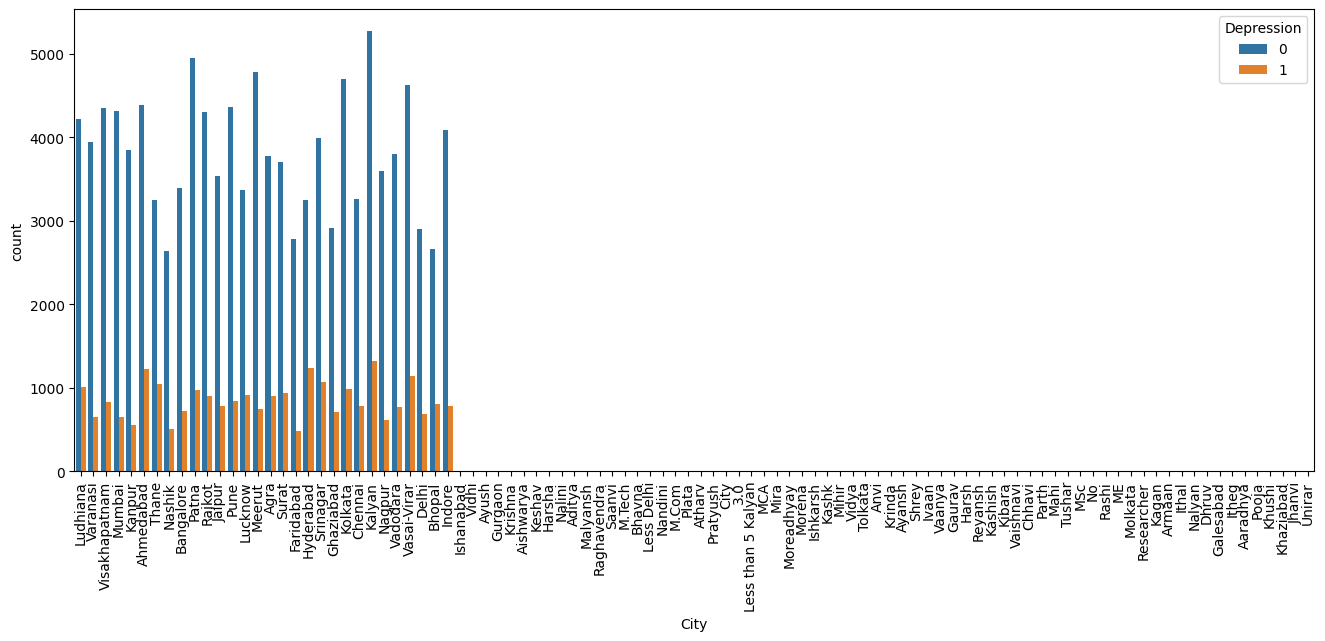

In [25]:
plt.figure(figsize=(16,6))
sns.countplot(data=df,x='City',hue='Depression')
plt.xticks(rotation=90);

In [26]:
(df['City'] == 'Kolkata').sum()

5688

In [27]:
city = df['City'].value_counts()[df['City'].value_counts()>100].index.to_list()

In [28]:
df['City'] = df['City'].apply(lambda x: x if x in city else 'Others')

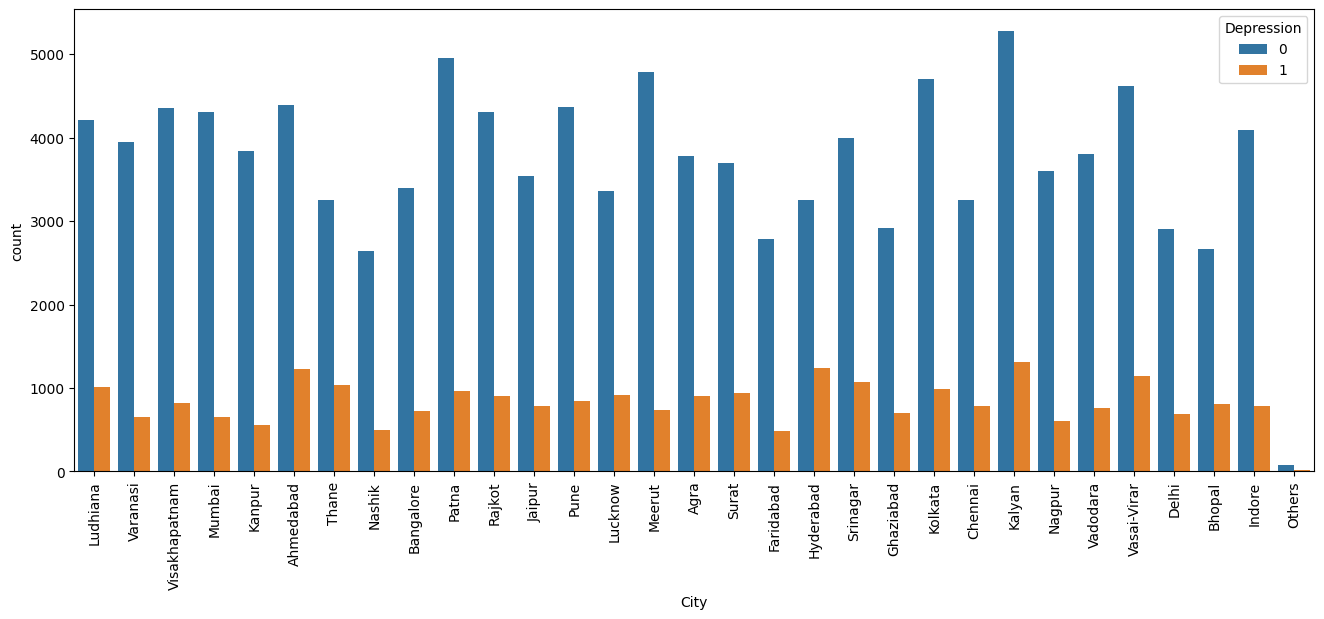

In [29]:
plt.figure(figsize=(16,6))
sns.countplot(data=df,x='City',hue='Depression')
plt.xticks(rotation=90);

<Axes: xlabel='Working Professional or Student', ylabel='count'>

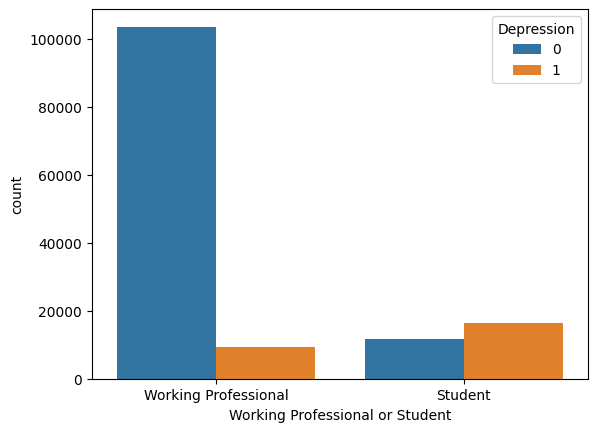

In [30]:
sns.countplot(data=df,x='Working Professional or Student',hue='Depression')

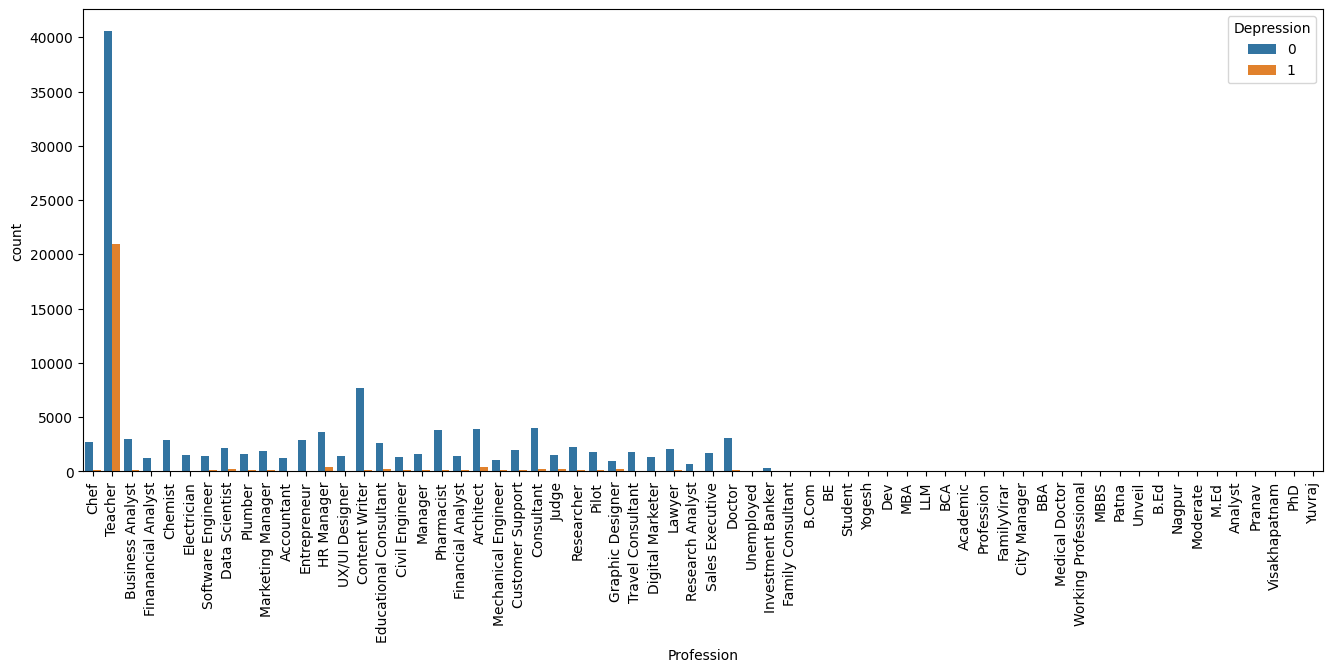

In [31]:
plt.figure(figsize=(16,6))
sns.countplot(data=df,x='Profession',hue='Depression')
plt.xticks(rotation=90);

In [32]:
df['Profession'].value_counts()[df['Profession'].value_counts()<100].sort_values(ascending=False)

Profession
Student                 7
Academic                5
Profession              3
Yogesh                  3
BCA                     3
Unemployed              3
LLM                     2
PhD                     2
MBA                     2
Medical Doctor          1
MBBS                    1
Working Professional    1
B.Com                   1
BBA                     1
City Manager            1
FamilyVirar             1
Unveil                  1
Patna                   1
Analyst                 1
B.Ed                    1
Nagpur                  1
Moderate                1
M.Ed                    1
Pranav                  1
Visakhapatnam           1
Family Consultant       1
BE                      1
Dev                     1
Yuvraj                  1
Name: count, dtype: int64

In [33]:
prof = df['Profession'].value_counts()[df['Profession'].value_counts()>100].index.to_list()
df['Profession'] = df['Profession'].apply(lambda x: x if x in prof else 'missing')

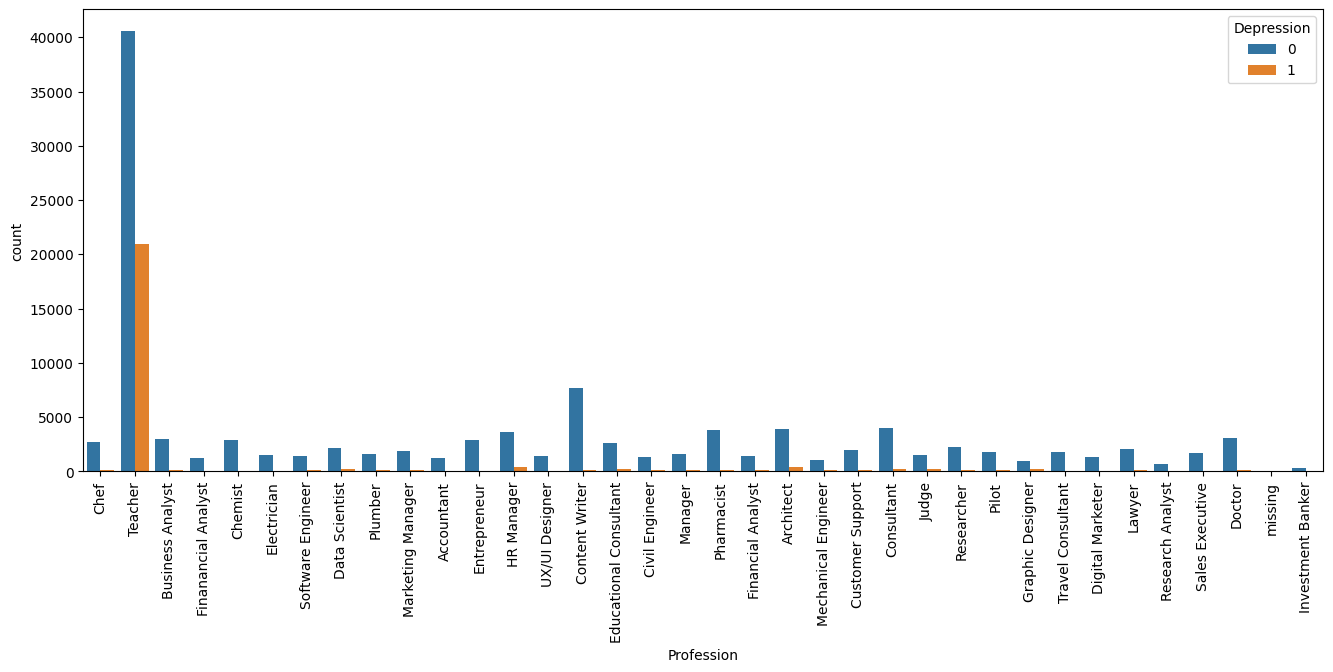

In [34]:
plt.figure(figsize=(16,6))
sns.countplot(data=df,x='Profession',hue='Depression')
plt.xticks(rotation=90);

<Axes: xlabel='Work Pressure', ylabel='count'>

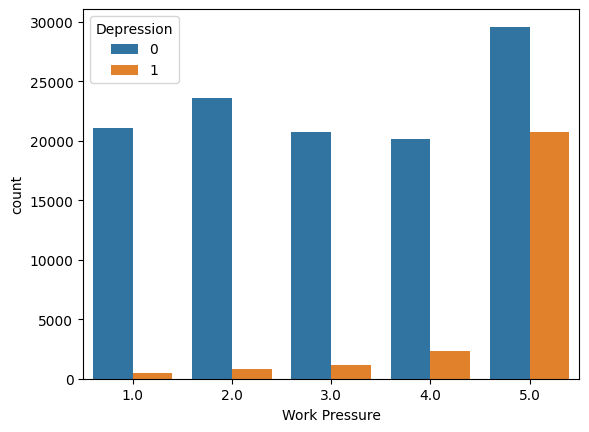

In [35]:
sns.countplot(data=df,x='Work Pressure',hue='Depression')

<Axes: xlabel='Job Satisfaction', ylabel='count'>

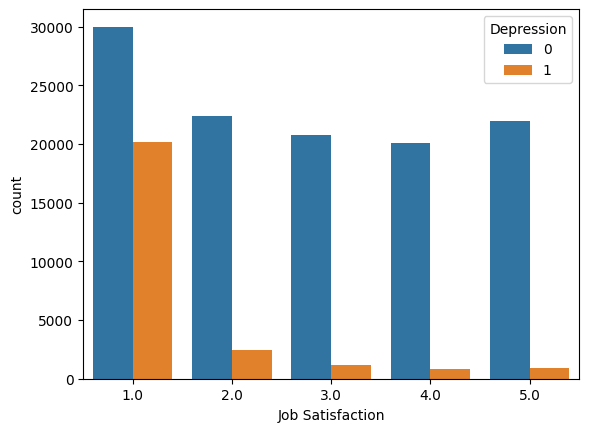

In [36]:
sns.countplot(data=df,x='Job Satisfaction',hue='Depression')

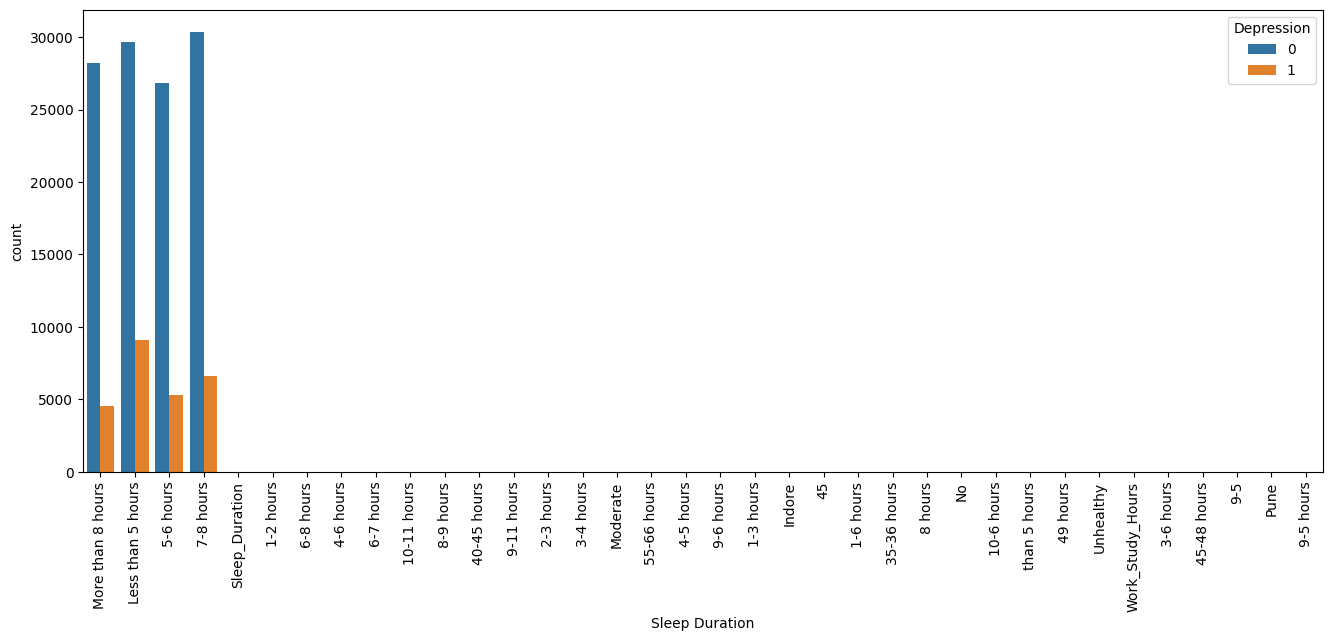

In [37]:
plt.figure(figsize=(16,6))
sns.countplot(data=df,x='Sleep Duration',hue='Depression')
plt.xticks(rotation=90);

In [38]:
df['Sleep Duration'].value_counts()

Sleep Duration
Less than 5 hours    38781
7-8 hours            36968
More than 8 hours    32724
5-6 hours            32138
3-4 hours               12
6-7 hours                8
4-5 hours                7
2-3 hours                5
4-6 hours                5
6-8 hours                4
1-6 hours                4
No                       4
9-11 hours               2
10-11 hours              2
Sleep_Duration           2
Unhealthy                2
45                       2
8-9 hours                2
10-6 hours               1
9-5                      1
45-48 hours              1
3-6 hours                1
Work_Study_Hours         1
49 hours                 1
than 5 hours             1
Pune                     1
9-6 hours                1
8 hours                  1
35-36 hours              1
Indore                   1
1-3 hours                1
55-66 hours              1
Moderate                 1
40-45 hours              1
1-2 hours                1
9-5 hours                1
Name: count, 

In [39]:
sleep_list = df['Sleep Duration'].value_counts()[df['Sleep Duration'].value_counts()>100].index.to_list()
df['Sleep Duration'] = df['Sleep Duration'].apply(lambda x: x if x in sleep_list else 'others')

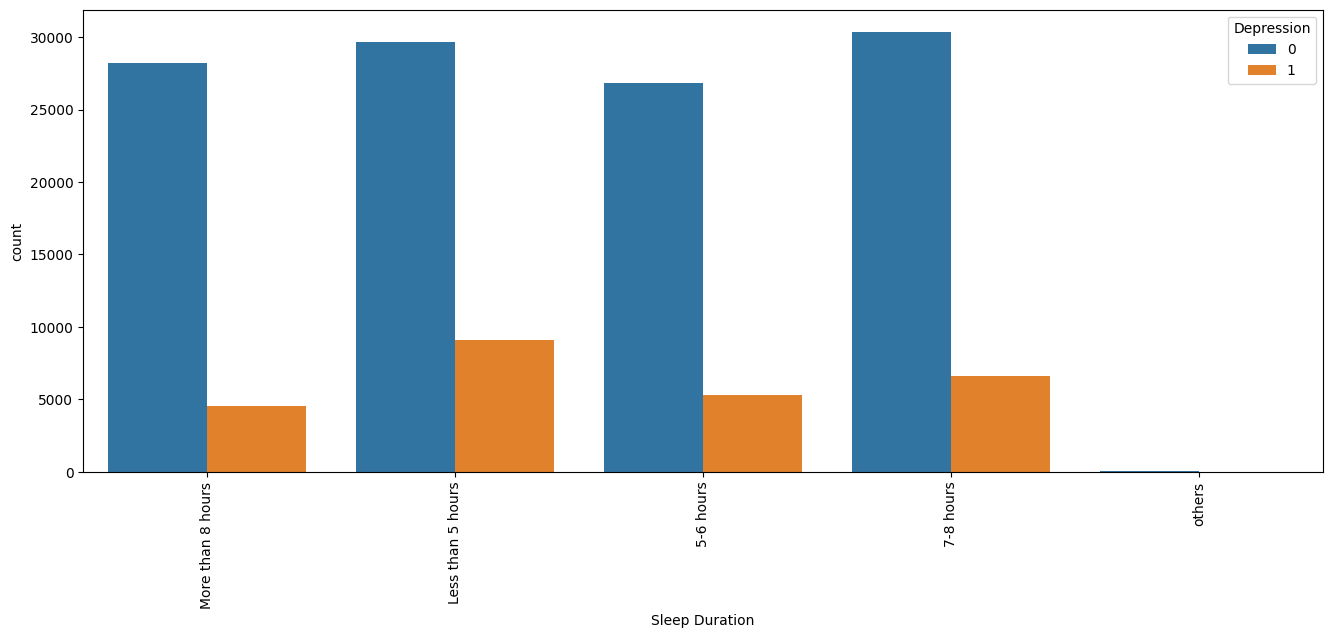

In [40]:
plt.figure(figsize=(16,6))
sns.countplot(data=df,x='Sleep Duration',hue='Depression')
plt.xticks(rotation=90);

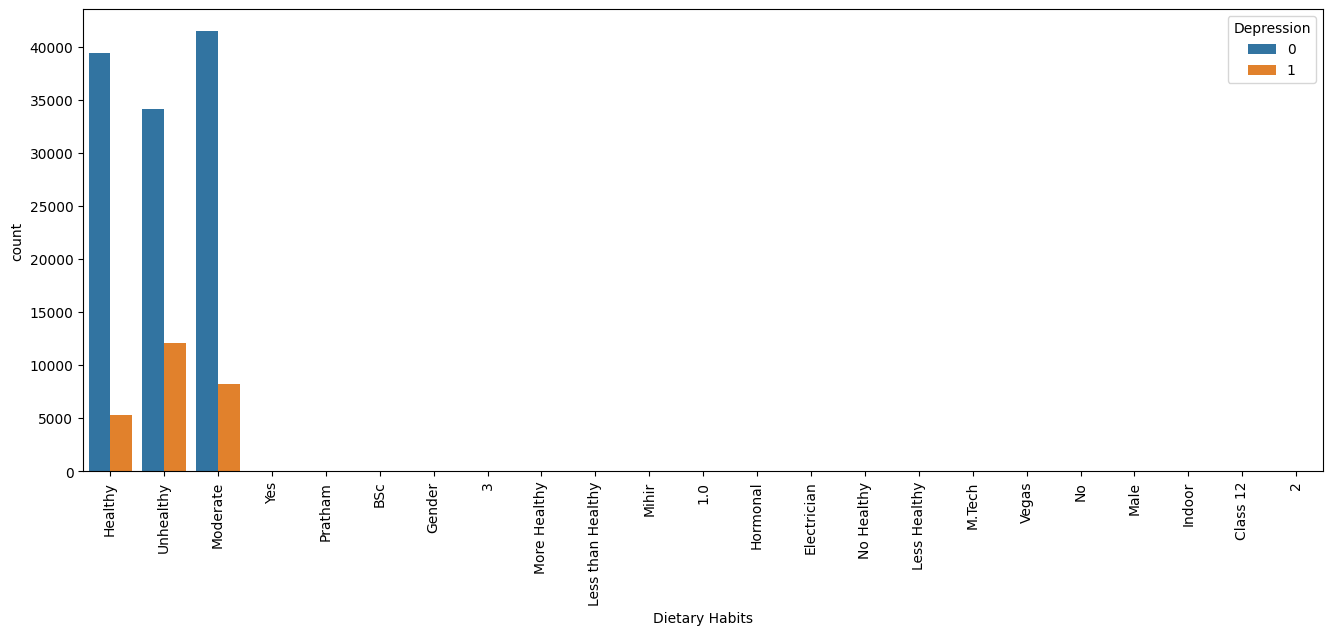

In [41]:
plt.figure(figsize=(16,6))
sns.countplot(data=df,x='Dietary Habits',hue='Depression')
plt.xticks(rotation=90);

In [42]:
df['Dietary Habits'].value_counts()

Dietary Habits
Moderate             49704
Unhealthy            46224
Healthy              44739
Yes                      2
No                       2
More Healthy             2
No Healthy               1
Class 12                 1
Indoor                   1
Male                     1
Vegas                    1
M.Tech                   1
Less Healthy             1
1.0                      1
Electrician              1
Hormonal                 1
Mihir                    1
Less than Healthy        1
3                        1
Gender                   1
BSc                      1
Pratham                  1
2                        1
Name: count, dtype: int64

In [43]:
map_diet = {
    'Healthy':'Healthy',
    'Unhealthy':'Unhealthy',
    'Moderate':'Moderate',
    'More Healthy':'Healthy',
    'No Healthy':'Unhealthy',
    'Less Healthy':'Moderate',
    'Less than Healthy':'Moderate'  
}
df['Dietary Habits'] = df['Dietary Habits'].map(map_diet).fillna('others')

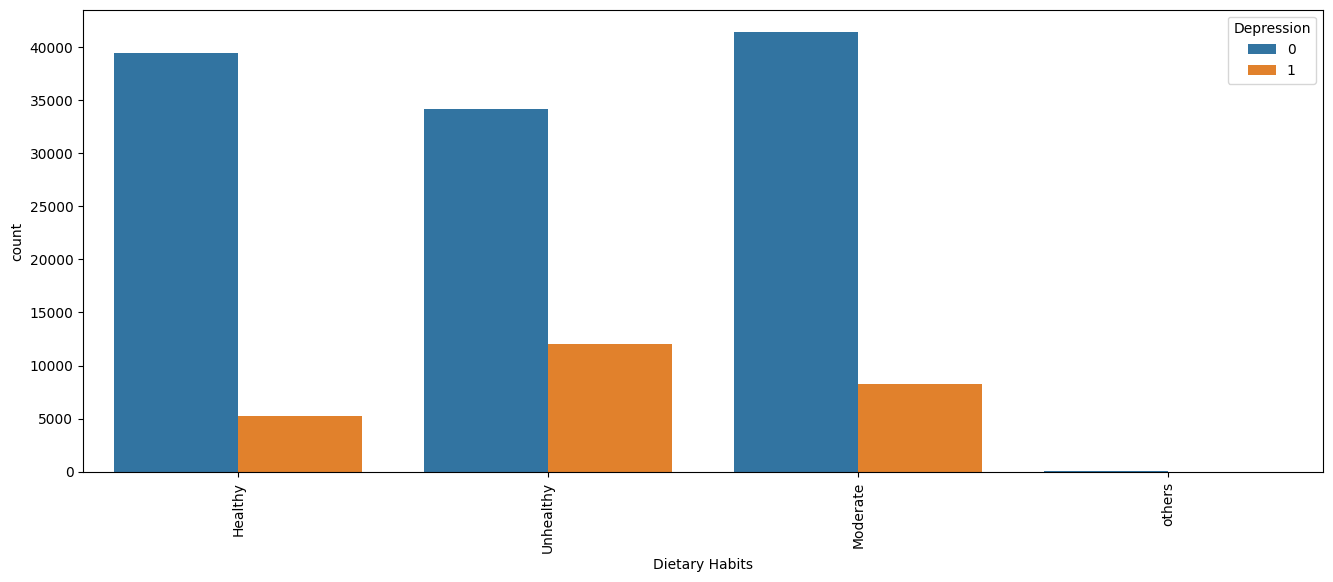

In [44]:
plt.figure(figsize=(16,6))
sns.countplot(data=df,x='Dietary Habits',hue='Depression')
plt.xticks(rotation=90);

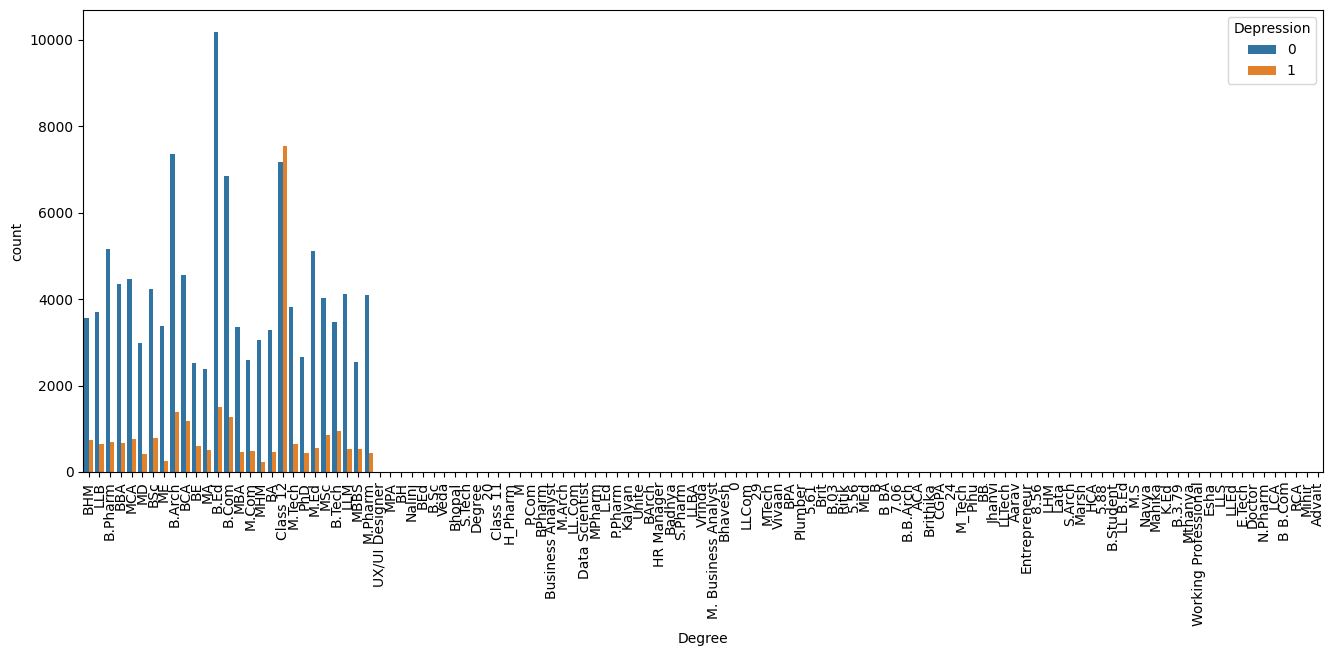

In [45]:
plt.figure(figsize=(16,6))
sns.countplot(data=df,x= 'Degree',hue='Depression')
plt.xticks(rotation=90);

In [46]:
df['Degree'].value_counts()[df['Degree'].value_counts()<100].sort_values(ascending=False)

Degree
M.Arch            5
UX/UI Designer    4
B.Sc              3
Kalyan            3
M                 3
                 ..
N.Pharm           1
LCA               1
B B.Com           1
RCA               1
Advait            1
Name: count, Length: 88, dtype: int64

In [47]:
degree_list = df['Degree'].value_counts()[df['Degree'].value_counts()>100].index.to_list()

In [48]:
df['Degree'] = df['Degree'].apply(lambda x: x if x in degree_list else 'others')

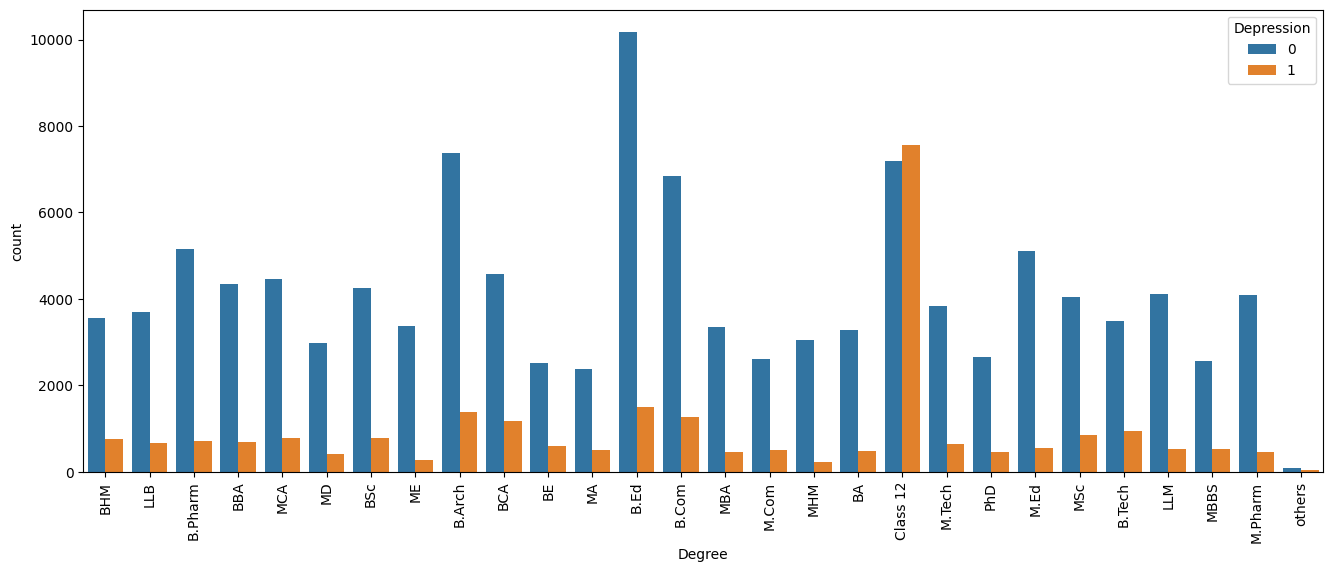

In [49]:
plt.figure(figsize=(16,6))
sns.countplot(data=df,x= 'Degree',hue='Depression')
plt.xticks(rotation=90);

<Axes: xlabel='Have you ever had suicidal thoughts ?', ylabel='count'>

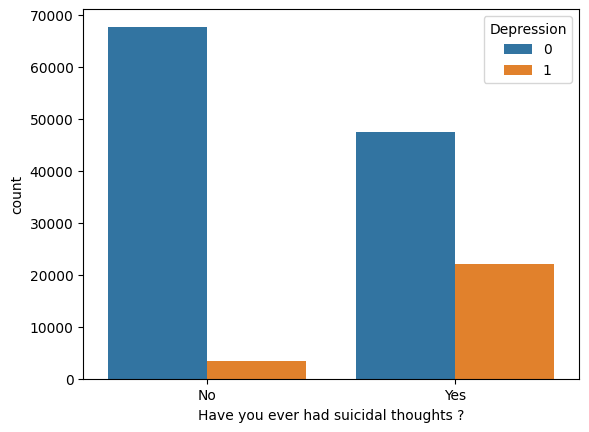

In [50]:
sns.countplot(data=df,x='Have you ever had suicidal thoughts ?',hue='Depression')

<Axes: xlabel='Work/Study Hours', ylabel='count'>

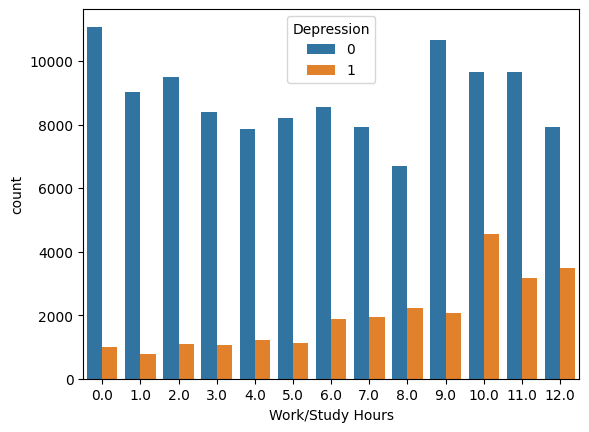

In [51]:
sns.countplot(data=df,x='Work/Study Hours',hue='Depression')

<Axes: xlabel='Financial Stress', ylabel='count'>

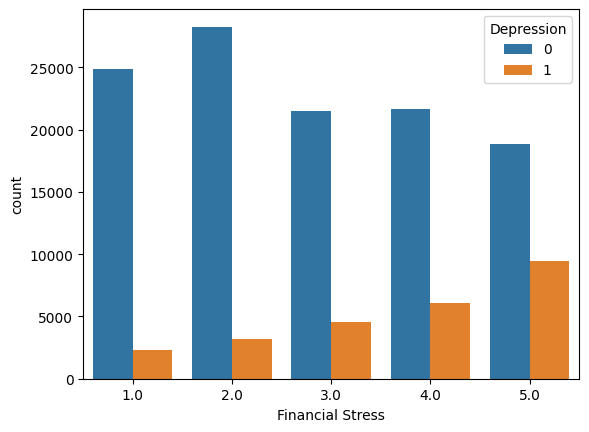

In [52]:
sns.countplot(data=df,x='Financial Stress',hue='Depression')

<Axes: xlabel='Family History of Mental Illness', ylabel='count'>

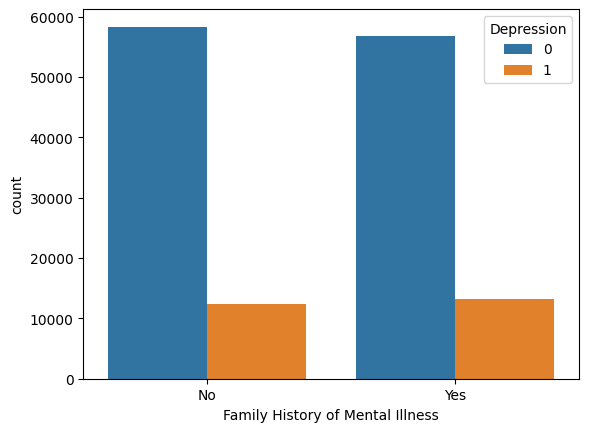

In [53]:
sns.countplot(data=df,x='Family History of Mental Illness',hue='Depression')

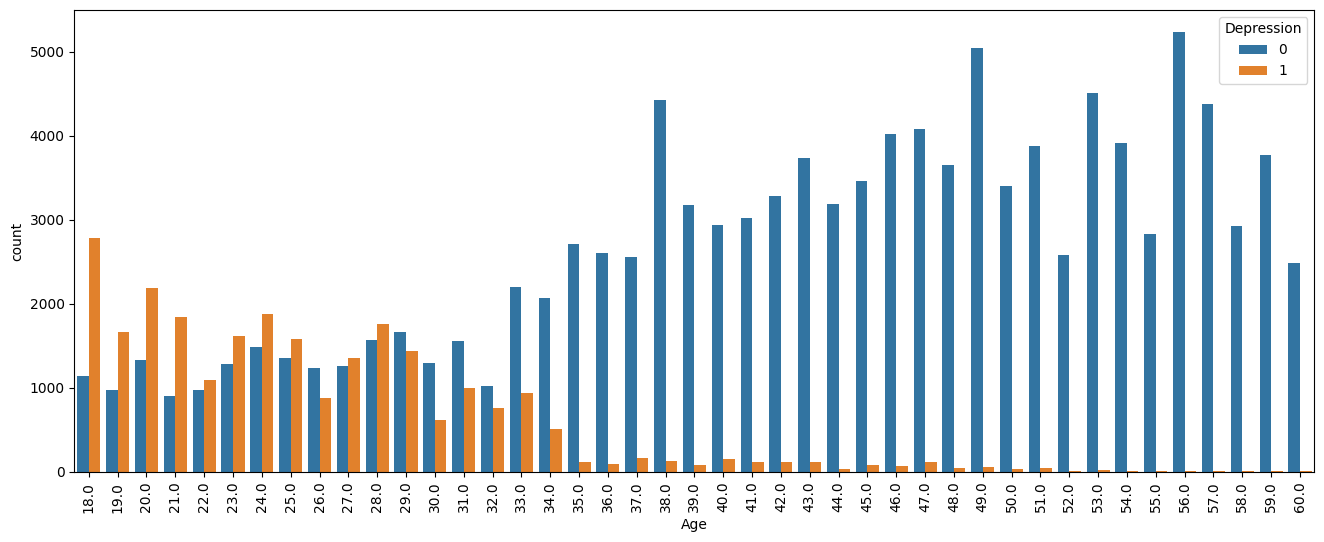

In [54]:
plt.figure(figsize=(16,6))
sns.countplot(data=df,x='Age',hue="Depression")
plt.xticks(rotation=90);

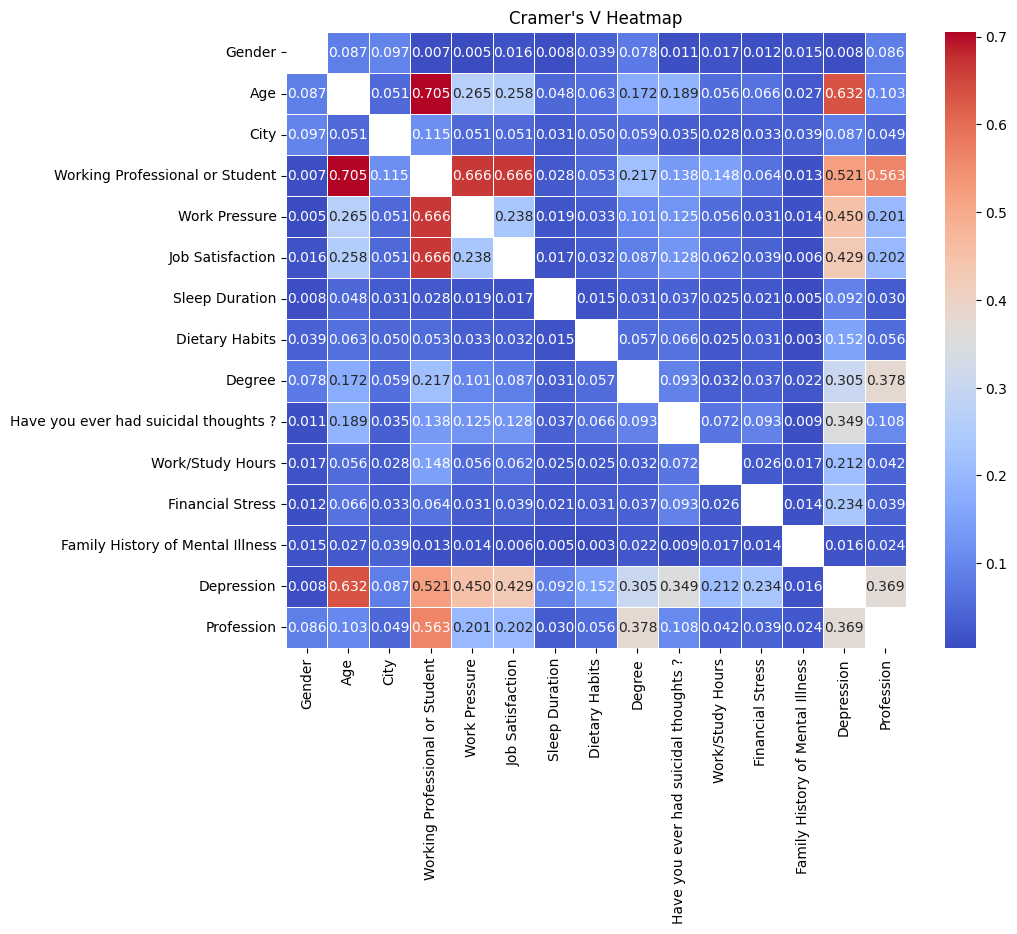

In [55]:
cat_col = df.columns.to_list()
def cramers_v(chi2, n, table):
    r, c = table.shape
    return np.sqrt(chi2 / (n * (min(r, c) - 1)))

cramers_v_df = pd.DataFrame(index=cat_col, columns=cat_col)
for col1 in cat_col:
    for col2 in cat_col:
        if col1 != col2:
            contingency_table = pd.crosstab(df[col1], df[col2])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            cramers_v_df.loc[col1, col2] = cramers_v(chi2, df.shape[0], contingency_table)

plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_df.astype(float), annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5)
plt.title("Cramer's V Heatmap")
plt.show()

# Pre-Processing

In [56]:
df.sample(5)

,Gender,Age,City,Working Professional or Student,Work Pressure,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Profession
71901,Male,46.0,Visakhapatnam,Working Professional,4.0,4.0,Less than 5 hours,Unhealthy,M.Pharm,No,1.0,5.0,No,0,Chemist
104397,Male,45.0,Vadodara,Working Professional,1.0,2.0,More than 8 hours,Moderate,BBA,No,10.0,2.0,No,0,Research Analyst
97837,Male,46.0,Meerut,Working Professional,4.0,4.0,More than 8 hours,Moderate,B.Com,Yes,7.0,1.0,Yes,0,Marketing Manager
4759,Male,37.0,Kolkata,Working Professional,4.0,1.0,5-6 hours,Unhealthy,MSc,Yes,12.0,2.0,Yes,0,Software Engineer
112332,Male,21.0,Visakhapatnam,Student,5.0,1.0,Less than 5 hours,Moderate,B.Ed,No,5.0,2.0,No,1,Teacher


In [57]:
oe = OrdinalEncoder()
df['Sleep Duration'] = oe.fit_transform(df[['Sleep Duration']])
df['Dietary Habits'] = oe.fit_transform(df[['Dietary Habits']])

In [58]:
cols = ['Gender','City','Working Professional or Student','Degree','Have you ever had suicidal thoughts ?','Family History of Mental Illness','Profession']
dum_df = pd.get_dummies(df,columns=cols,drop_first=True).astype(int)

In [59]:
dum_df.sample(5)

,Age,Work Pressure,Job Satisfaction,Sleep Duration,Dietary Habits,Work/Study Hours,Financial Stress,Depression,Gender_Male,City_Ahmedabad,...,Profession_Pilot,Profession_Plumber,Profession_Research Analyst,Profession_Researcher,Profession_Sales Executive,Profession_Software Engineer,Profession_Teacher,Profession_Travel Consultant,Profession_UX/UI Designer,Profession_missing
111153,54,2,2,1,0,4,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
121278,41,5,2,1,1,8,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
549,59,5,2,2,1,7,2,0,1,0,...,0,0,0,0,0,0,1,0,0,0
78802,21,5,1,2,0,6,4,1,1,0,...,0,0,0,0,0,0,0,0,0,0
17779,19,5,1,2,1,10,4,1,0,0,...,0,0,0,0,0,0,1,0,0,0


# Model Training

In [60]:
X = dum_df.drop('Depression',axis=1)
y = dum_df['Depression']

In [61]:
X

,Age,Work Pressure,Job Satisfaction,Sleep Duration,Dietary Habits,Work/Study Hours,Financial Stress,Gender_Male,City_Ahmedabad,City_Bangalore,...,Profession_Pilot,Profession_Plumber,Profession_Research Analyst,Profession_Researcher,Profession_Sales Executive,Profession_Software Engineer,Profession_Teacher,Profession_Travel Consultant,Profession_UX/UI Designer,Profession_missing
0,49,5,2,3,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,26,4,3,2,2,7,3,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,33,5,1,0,0,3,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,22,5,1,2,1,10,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,30,1,1,0,2,9,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,18,5,4,0,2,2,4,0,1,0,...,0,0,0,0,0,0,1,0,0,0
140696,41,5,4,1,1,6,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140697,24,3,1,3,1,4,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140698,49,5,2,0,1,10,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [62]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=101)

In [63]:
y_train.value_counts()

Depression
0    80570
1    17913
Name: count, dtype: int64

In [64]:
n_estimators=[40,60,80,120,140,160,180,200,250,300,350,400]
max_features= [2,3,4,5,6,7,8,9,'sqrt','log2']
criterion = ['gini','entropy','log_loss']
max_depth = [3,4,5,6,7,8,9,10]
bootstrap = [True,False]

param_grid = {
    'n_estimators':n_estimators,
    'max_features':max_features,
    'criterion':criterion,
    'max_depth':max_depth,
    'bootstrap':bootstrap,
    'class_weight': [{0:1,1:1.5},None]
}

### Random Forest

In [65]:
brf = RandomForestClassifier(n_jobs=-1)
rs = RandomizedSearchCV(estimator=brf,param_distributions=param_grid,verbose=3,random_state=101)

In [66]:
rs.fit(X_train,y_train)
y_hat = rs.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END bootstrap=True, class_weight={0: 1, 1: 1.5}, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=400;, score=0.914 total time=   8.4s
[CV 2/5] END bootstrap=True, class_weight={0: 1, 1: 1.5}, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=400;, score=0.911 total time=   8.9s
[CV 3/5] END bootstrap=True, class_weight={0: 1, 1: 1.5}, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=400;, score=0.918 total time=   8.5s
[CV 4/5] END bootstrap=True, class_weight={0: 1, 1: 1.5}, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=400;, score=0.915 total time=   8.5s
[CV 5/5] END bootstrap=True, class_weight={0: 1, 1: 1.5}, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=400;, score=0.911 total time=   8.4s
[CV 1/5] END bootstrap=True, class_weight={0: 1, 1: 1.5}, criterion=entropy, max_depth=6, max_features=5, n_estimators=160;, score=0.902 total t

In [67]:
rs.best_params_

{'n_estimators': 400,
 'max_features': 'sqrt',
 'max_depth': 7,
 'criterion': 'entropy',
 'class_weight': {0: 1, 1: 1.5},
 'bootstrap': True}

In [68]:
from sklearn.metrics import classification_report
print(classification_report(y_pred=y_hat,y_true=y_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     34557
           1       0.77      0.74      0.75      7650

    accuracy                           0.91     42207
   macro avg       0.86      0.85      0.85     42207
weighted avg       0.91      0.91      0.91     42207



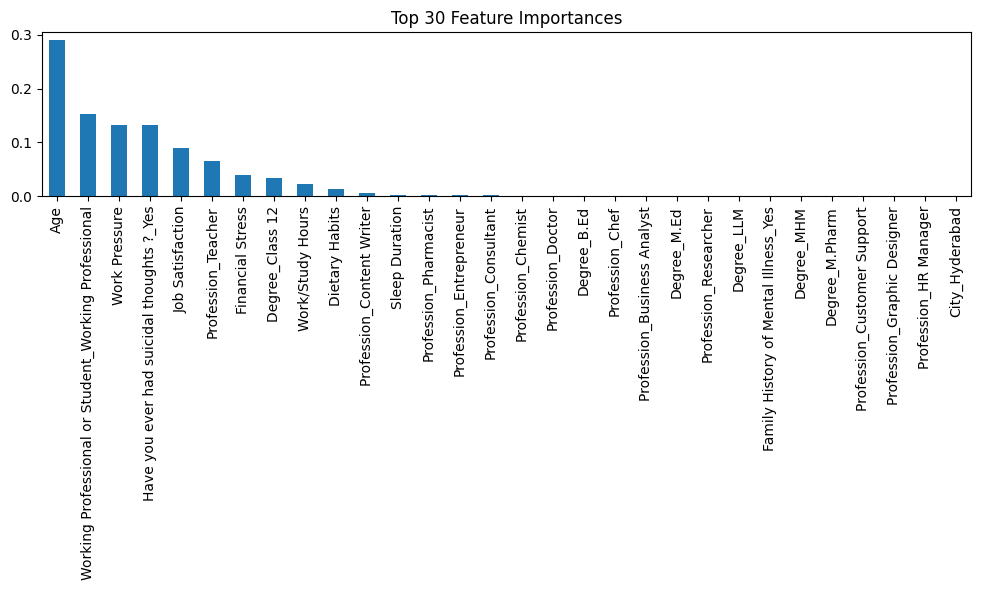

In [69]:
feature_importances = pd.Series(
    rs.best_estimator_.feature_importances_, 
    index=X.columns
).sort_values(ascending=False)

top_features = feature_importances.head(30)

# Visualize feature importance
plt.figure(figsize=(10, 6))
top_features.plot(kind='bar')
plt.title('Top 30 Feature Importances')
plt.tight_layout()

In [70]:
X_best_train = X_train[top_features.index.to_list()]
X_best_test = X_test[top_features.index.to_list()]
rs1 = RandomizedSearchCV(estimator=brf,param_distributions=param_grid,verbose=3,random_state=101)
rs1.fit(X_best_train,y_train)
y_best_pred = rs1.predict(X_best_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END bootstrap=True, class_weight={0: 1, 1: 1.5}, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=400;, score=0.923 total time=   6.4s
[CV 2/5] END bootstrap=True, class_weight={0: 1, 1: 1.5}, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=400;, score=0.922 total time=   6.4s
[CV 3/5] END bootstrap=True, class_weight={0: 1, 1: 1.5}, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=400;, score=0.926 total time=   6.9s
[CV 4/5] END bootstrap=True, class_weight={0: 1, 1: 1.5}, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=400;, score=0.925 total time=   6.3s
[CV 5/5] END bootstrap=True, class_weight={0: 1, 1: 1.5}, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=400;, score=0.925 total time=   6.3s
[CV 1/5] END bootstrap=True, class_weight={0: 1, 1: 1.5}, criterion=entropy, max_depth=6, max_features=5, n_estimators=160;, score=0.921 total t

In [71]:
rs1.best_params_

{'n_estimators': 200,
 'max_features': 6,
 'max_depth': 10,
 'criterion': 'log_loss',
 'class_weight': None,
 'bootstrap': True}

In [72]:
print(classification_report(y_pred=y_best_pred,y_true=y_test))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     34557
           1       0.81      0.77      0.79      7650

    accuracy                           0.93     42207
   macro avg       0.88      0.87      0.87     42207
weighted avg       0.92      0.93      0.93     42207



### AdaBoost 

In [73]:
param_grid2 = {
    'n_estimators': [40, 60, 80, 120, 140, 160, 180, 200, 250, 300],
    'learning_rate': [0.1, 0.2, 0.5, 1, 5]
}

In [74]:
ab = AdaBoostClassifier(algorithm='SAMME')
rs2 = RandomizedSearchCV(estimator=ab,param_distributions=param_grid2,random_state=101,verbose=3)

In [75]:
rs2.fit(X_train,y_train)
y_pred = rs2.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .learning_rate=1, n_estimators=200;, score=0.931 total time=  19.2s
[CV 2/5] END .learning_rate=1, n_estimators=200;, score=0.927 total time=  19.2s
[CV 3/5] END .learning_rate=1, n_estimators=200;, score=0.933 total time=  19.2s
[CV 4/5] END .learning_rate=1, n_estimators=200;, score=0.929 total time=  19.3s
[CV 5/5] END .learning_rate=1, n_estimators=200;, score=0.931 total time=  19.2s
[CV 1/5] END learning_rate=0.2, n_estimators=140;, score=0.926 total time=  13.6s
[CV 2/5] END learning_rate=0.2, n_estimators=140;, score=0.926 total time=  13.7s
[CV 3/5] END learning_rate=0.2, n_estimators=140;, score=0.930 total time=  13.5s
[CV 4/5] END learning_rate=0.2, n_estimators=140;, score=0.929 total time=  13.5s
[CV 5/5] END learning_rate=0.2, n_estimators=140;, score=0.928 total time=  13.6s
[CV 1/5] END learning_rate=0.5, n_estimators=60;, score=0.927 total time=   5.8s
[CV 2/5] END learning_rate=0.5, n_estimator

In [76]:
rs2.best_params_

{'n_estimators': 200, 'learning_rate': 1}

In [77]:
print(classification_report(y_pred=y_pred,y_true=y_test))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     34557
           1       0.81      0.78      0.80      7650

    accuracy                           0.93     42207
   macro avg       0.88      0.87      0.88     42207
weighted avg       0.93      0.93      0.93     42207



### LightGBM

In [78]:
param_grid3 = { 
    'n_estimators': [40, 60, 80, 120, 140, 160, 180, 200, 250, 300, 350, 400], 
    'max_depth': [3, 4, 5, 6, 7, 8],
    'num_leaves': [2**depth for depth in range(3, 9)],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1], 
    'subsample': [0.7, 0.8, 0.9, 1.0], 
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0], 
    'reg_alpha': [0, 0.1, 0.5, 1.0], 
    'reg_lambda': [0, 0.1, 0.5, 1.0], 
    'scale_pos_weight': [1, 10, 20],
    'boosting_type': ['gbdt', 'dart', 'goss']
}

In [79]:
model = lgb.LGBMClassifier(objective='binary',force_col_wise=True)
rs3 = RandomizedSearchCV(estimator=model,param_distributions=param_grid3,cv=5,n_jobs=-1,verbose=-1)
rs3.fit(X_train,y_train)
y_pred2 = rs3.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14331, number of negative: 64456
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 78787, number of used features: 102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181895 -> initscore=-1.503558
[LightGBM] [Info] Start training from score -1.503558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14330, number of negative: 64456
[LightGBM] [Info] Total Bins 276
[LightGBM] [Info] Number of data points in the train set: 78786, number of used features: 103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181885 -> initscore=-1.503628
[LightGBM] [Info] Start training from score -1.503628
[LightGBM] [Warning] Found

In [80]:
rs3.best_params_

{'subsample': 1.0,
 'scale_pos_weight': 1,
 'reg_lambda': 0,
 'reg_alpha': 0.1,
 'num_leaves': 64,
 'n_estimators': 140,
 'max_depth': 7,
 'learning_rate': 0.2,
 'colsample_bytree': 1.0,
 'boosting_type': 'dart'}

In [81]:
print(classification_report(y_pred=y_pred2,y_true=y_test))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     34557
           1       0.81      0.79      0.80      7650

    accuracy                           0.93     42207
   macro avg       0.88      0.88      0.88     42207
weighted avg       0.93      0.93      0.93     42207



# Performance Metrics

In [82]:
models = pd.DataFrame({
    'Model': ['Random Forest','Random Forest (with K best Features)','AdaBoost','LightGBM'],
    'Best Params':[rs.best_params_,rs1.best_params_,rs2.best_params_,rs3.best_params_],
    'Accuracy':[rs.best_score_,rs1.best_score_,rs2.best_score_,rs3.best_score_]
})
models

,Model,Best Params,Accuracy
0,Random Forest,"{'n_estimators': 400, 'max_features': 'sqrt', ...",0.913792
1,Random Forest (with K best Features),"{'n_estimators': 200, 'max_features': 6, 'max_...",0.928089
2,AdaBoost,"{'n_estimators': 200, 'learning_rate': 1}",0.930232
3,LightGBM,"{'subsample': 1.0, 'scale_pos_weight': 1, 'reg...",0.931003


### Confusion Matrix

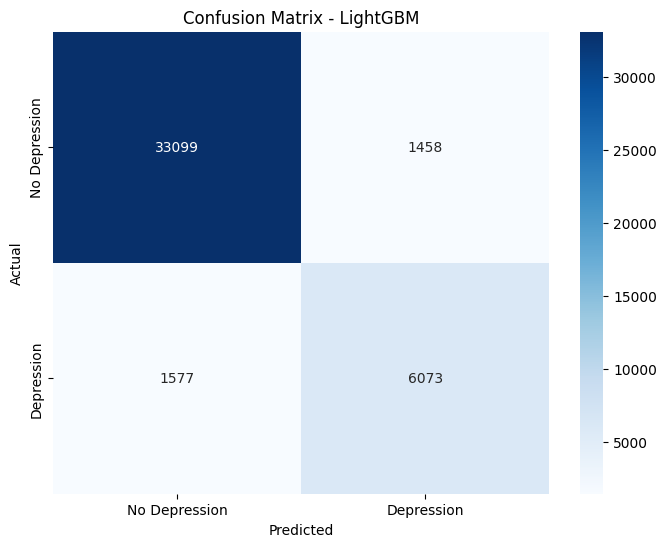

In [83]:
conf_matrix = confusion_matrix(y_test, y_pred2)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Depression", "Depression"], yticklabels=["No Depression", "Depression"])
plt.title('Confusion Matrix - LightGBM')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### ROC Curve

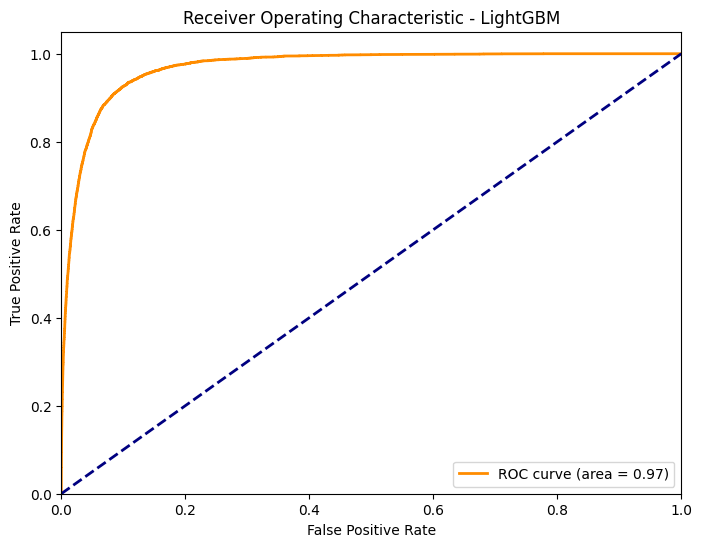

In [84]:
y_probs = rs3.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - LightGBM')
plt.legend(loc='lower right')
plt.show()

![img](https://imgs.search.brave.com/3hpAPPJu8teydVCaEsD71b24BALwMogfJnEMVLOqvis/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly90My5m/dGNkbi5uZXQvanBn/LzAzLzk3LzU4LzU4/LzM2MF9GXzM5NzU4/NTg3OV9VNkNEN2s2/RGc0c2tySW5PUHdp/T1RNa1pnT3NIcnVE/Qi5qcGc)